# NLI Results Analysis

Maybe: 
- Clustering: Apply hierarchical clustering on the performance matrix to detect groupings of languages with similar transfer characteristics.

In [66]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from lang2vec import lang2vec as l2v
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import math

### Load data

In [2]:
path = "../nli/results.json"

# Results structure: {lang_eval: {lang_train: {data_fraction: {metric: score}}}}
with open(path, 'r') as file:
    results_per_eval = json.load(file)

print(results_per_eval.keys())

dict_keys(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'])


In [3]:
def invert_structure(original):
    transformed = defaultdict(lambda: defaultdict(dict))

    for lang_eval in original:
        for lang_train in original[lang_eval]:
            for data_frac in original[lang_eval][lang_train]:
                metrics = original[lang_eval][lang_train][data_frac]
                # Initialize nested dict if needed
                if data_frac not in transformed[lang_train][lang_eval]:
                    transformed[lang_train][lang_eval][data_frac] = {}
                # Copy all metrics
                transformed[lang_train][lang_eval][data_frac].update(metrics)

    return dict(transformed)

# Restructure results to {lang_train: {lang_eval: {data_fraction: {metric: score}}}} for easier plotting
results_per_train = invert_structure(results_per_eval)
print(results_per_train.keys())

dict_keys(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'])


### Plot all results

In [70]:
def plot_results(results, lang_train, metrics='all'):
    if lang_train not in results:
        print(f"No results for training language: {lang_train}")
        return

    # Collect all unique metrics from the data
    if metrics == 'all':
        metrics = ["accuracy", "precision_micro", "recall_micro", "f1_micro", "precision_macro", "recall_macro", "f1_macro"]
    elif isinstance(metrics, str):
        metrics = [metrics]  # Convert single metric to list

    all_metrics = sorted(metrics)
    n_metrics = len(all_metrics)

    # Determine subplot layout (2 columns)
    n_cols = 3
    n_rows = math.ceil(n_metrics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5 * n_rows), sharex=True)
    axes = axes.flatten()  # Flatten in case of single row

    # Generate enough distinct colors
    lang_evals = sorted(results[lang_train].keys())
    colors = plt.get_cmap('tab20').colors
    color_map = {lang_eval: colors[i % len(colors)] for i, lang_eval in enumerate(lang_evals)}

    for i, metric in enumerate(all_metrics):
        ax = axes[i]

        for lang_eval in lang_evals:
            data_fractions = []
            values = []

            for data_frac in sorted(results[lang_train][lang_eval]):
                metrics = results[lang_train][lang_eval][data_frac]
                if metric in metrics and metrics[metric] is not None:
                    data_fractions.append(float(data_frac))
                    values.append(metrics[metric])

            if data_fractions:
                x_y = sorted(zip(data_fractions, values))
                x_sorted, y_sorted = zip(*x_y)
                ax.plot(x_sorted, y_sorted, 'o-', label=lang_eval, color=color_map[lang_eval], alpha=0.8)

        ax.set_ylabel(metric.capitalize())
        ax.set_title(f"{metric.capitalize()} vs. Data Fraction (Source language='{lang_train}')")
        ax.grid(True)
        ax.set_ylim(0, 1)
        ax.legend(title="lang_eval")

    # Hide any unused subplots
    for j in range(len(all_metrics), len(axes)):
        fig.delaxes(axes[j])

    axes[-1].set_xlabel("Data Fraction Used for Training")
    plt.tight_layout()
    plt.show()


In [ ]:
for lang in results_per_train.keys():
    plot_results(results_per_train, lang_train=lang, metrics='accuracy')


## RQ1.  Language Similarity: Does the language similarity affect the performance of zero-shot transfer learning?

- Determine whether closer languages result in better transfer performance in the zero-shot setting.  
    - Compute correlation between language similarity and performance (per language and overall) at X% of data.

In [ ]:
languages = list(results_per_eval.keys())
language_code_map = {
    'ar': 'arb',  # Arabic
    'bg': 'bul',  # Bulgarian
    'de': 'deu',  # German
    'el': 'ell',  # Greek
    'en': 'eng',  # English
    'es': 'spa',  # Spanish
    'fr': 'fra',  # French
    'hi': 'hin',  # Hindi
    'ru': 'rus',  # Russian
    'sw': 'swa',  # Swahili
    'th': 'tha',  # Thai
    'tr': 'tur',  # Turkish
    'ur': 'urd',  # Urdu
    'vi': 'vie',  # Vietnamese
    'zh': 'zho',  # Chinese
}

langs_three_digits = [language_code_map[lang] for lang in languages if lang in language_code_map]

len(languages), len(langs_three_digits)

(15, 15)

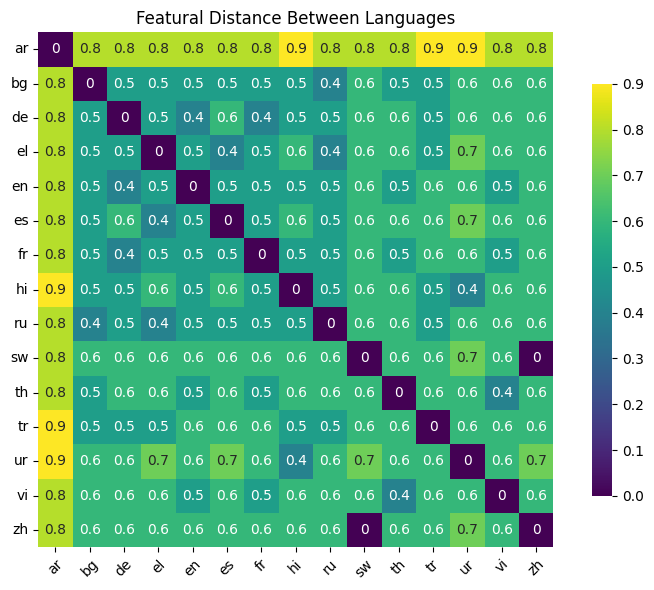

In [24]:
distance_matrix = l2v.featural_distance(langs_three_digits)
distance_df = pd.DataFrame(distance_matrix, index=languages, columns=languages)

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": 0.8})
plt.title("Featural Distance Between Languages")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Correlation (distance vs. accuracy) and accuracy heatmap

In [ ]:
def compute_correlation(results_per_eval, distance_df, metric='accuracy', data_fraction=1.0, visualize_heatmap=True):
    data_fraction = str(data_fraction)
    # 1. Extract accuracy and distances
    source_target_pairs = []
    accuracies = []
    distances = []

    for target_lang in results_per_eval:
        for source_lang in results_per_eval[target_lang]:
            try:
                acc = results_per_eval[target_lang][source_lang][data_fraction][metric]
                if acc is None:
                    continue
                dist = distance_df.loc[source_lang, target_lang]

                source_target_pairs.append((source_lang, target_lang))
                accuracies.append(acc)
                distances.append(dist)
            except KeyError:
                continue

    # 2. Correlation analysis
    correlation, pval = spearmanr(distances, accuracies)
    print(f"Spearman correlation for (data fraction = {data_fraction}): {correlation:.3f} (p = {pval:.3g})")

    # 4. Visualize metric heatmap if requested
    if visualize_heatmap:
        plot_heatmap(source_target_pairs, accuracies, metric=metric, data_fraction=data_fraction)


def plot_heatmap(source_target_pairs, accuracies, metric='accuracy', data_fraction='1.0'):
    heatmap_data = pd.DataFrame(index=languages, columns=languages)
    for (src, tgt), acc in zip(source_target_pairs, accuracies):
        heatmap_data.loc[src, tgt] = acc
    heatmap_data = heatmap_data.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, vmin=0, vmax=1)
    plt.title(f"{metric.capitalize()} of Transfer (source → target) (data fraction = {data_fraction})")
    plt.xlabel("Target Language")
    plt.ylabel("Source Language")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
data_fractions = list(results_per_eval[next(iter(results_per_eval))][next(iter(results_per_eval[next(iter(results_per_eval))]))].keys())

for frac in data_fractions:
    compute_correlation(results_per_eval, distance_df, metric = 'accuracy', data_fraction = frac, visualize_heatmap=False)

Spearman correlation for (data fraction = 0.0): nan (p = nan)
Spearman correlation for (data fraction = 0.25): nan (p = nan)
Spearman correlation for (data fraction = 0.5): -0.091 (p = 0.487)
Spearman correlation for (data fraction = 0.75): nan (p = nan)
Spearman correlation for (data fraction = 1.0): -0.259 (p = 0.0698)


/tmp/ipykernel_3570009/3653238567.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, pval = spearmanr(distances, accuracies)


Spearman correlation for (data fraction = 1.0): -0.259 (p = 0.0698)


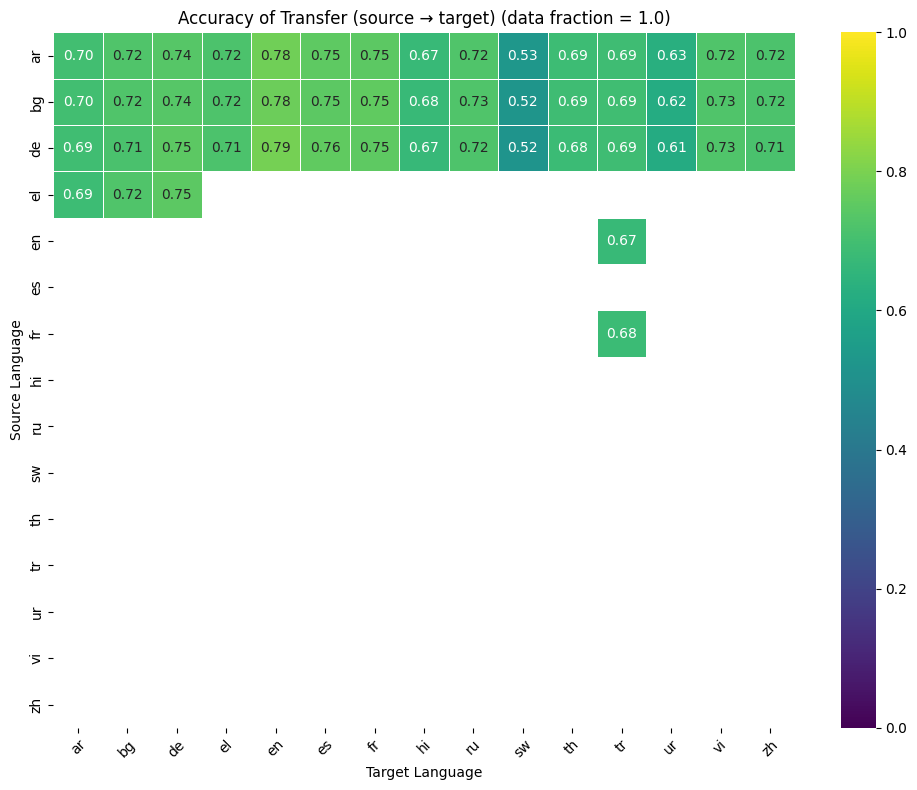

In [49]:
compute_correlation(results_per_eval, distance_df, metric = 'accuracy', data_fraction = 1.0, visualize_heatmap=True)

### Distance vs. accuracy per source language

In [59]:
def plot_distance_vs_accuracy_per_source(results_per_eval, distance_df, metric='accuracy', data_fraction=1.0):
    data_fraction = str(data_fraction)

    n_cols = 4
    n_rows = int(np.ceil(len(languages) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True)
    axes = axes.flatten()

    for i, source_lang in enumerate(languages):
        ax = axes[i]
        distances = []
        accuracies = []

        for target_lang in languages:
            if target_lang == source_lang:
                continue  # skip same-language
            try:
                acc = results_per_eval[target_lang][source_lang][data_fraction][metric]
                if acc is None:
                    continue
                dist = distance_df.loc[source_lang, target_lang]
                distances.append(dist)
                accuracies.append(acc)
            except KeyError:
                continue

        if distances and accuracies:
            ax.scatter(distances, accuracies, alpha=0.7)
            corr, _ = spearmanr(distances, accuracies)
            ax.set_title(f"{source_lang} (ρ={corr:.2f})")
        else:
            ax.set_title(f"{source_lang} (no data)")

        ax.set_xlim(0, 1)
        ax.set_xlabel("Featural Distance")
        if i % n_cols == 0:
            ax.set_ylabel("Accuracy")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Accuracy vs. Featural Distance (data_fraction = {data_fraction})", fontsize=16)
    plt.ylim(0, 1)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


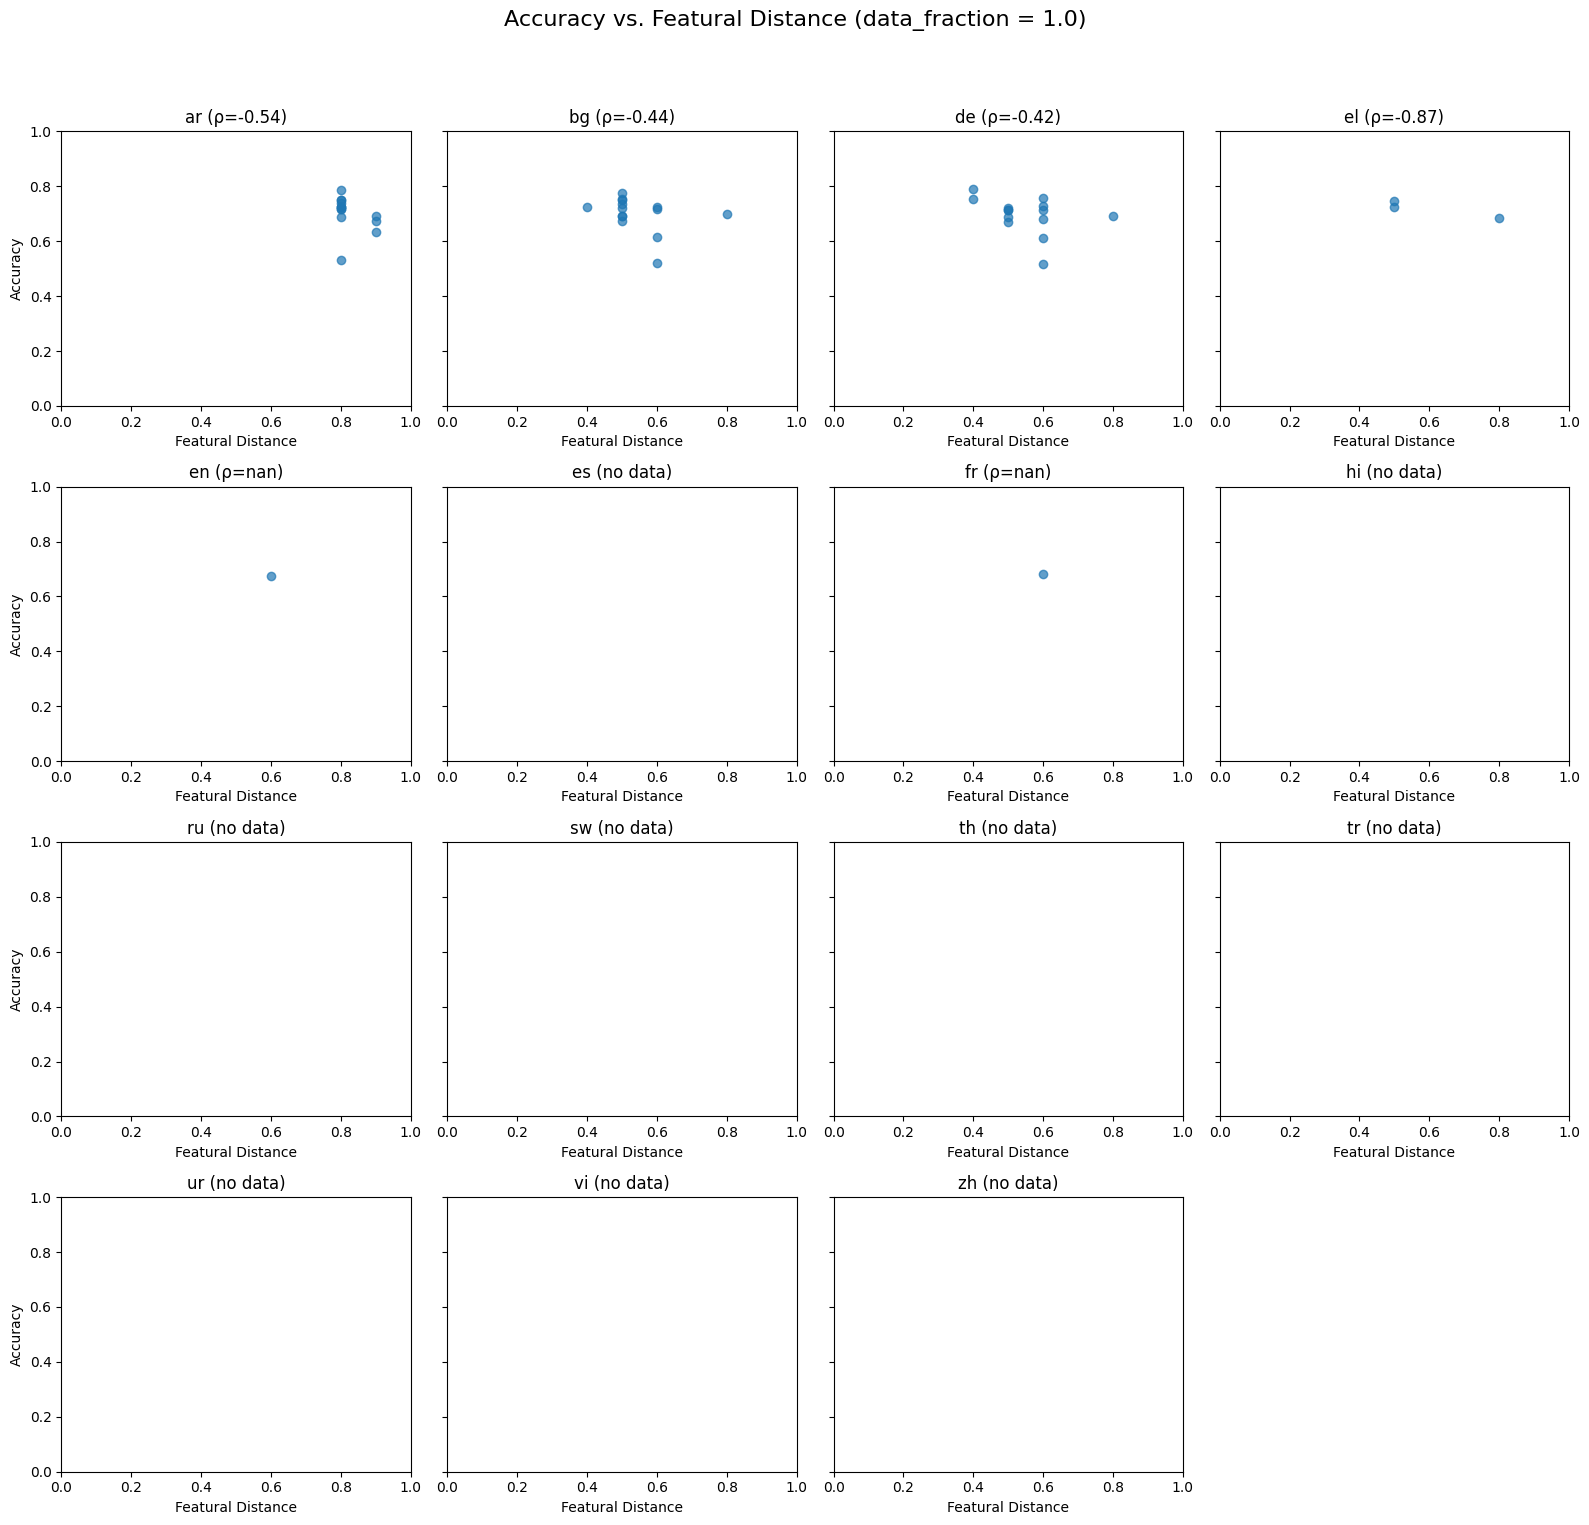

In [63]:
plot_distance_vs_accuracy_per_source(results_per_eval,distance_df,metric='accuracy',data_fraction=1.0)

## RQ2. Data Availability: Can increasing the amount of data provided during fine-tuning compensate for transferring form more distant language?
- Test whether more fine-tuning data improves cross-lingual transfer, especially from distant languages.
    -  Track accuracy as a function of data fraction used during fine-tuning

### Accuracy vs. Data Fraction (Per Source)

In [147]:
def plot_accuracy_vs_data_fraction_per_source(results_per_train, fractions, metric='accuracy'):
    source_langs = list(results_per_train.keys())
    all_target_langs = sorted({tgt for src in results_per_train for tgt in results_per_train[src]})

    # Assign fixed colors to each target language
    cmap_colors = plt.get_cmap('tab20').colors
    color_map = {lang: cmap_colors[i % len(cmap_colors)] for i, lang in enumerate(all_target_langs)}

    n_sources = len(source_langs)
    n_cols = 3
    n_rows = int(np.ceil(n_sources / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
    axes = axes.flatten()

    all_handles = {}

    for i, source_lang in enumerate(source_langs):
        ax = axes[i]
        for target_lang in results_per_train[source_lang]:
            present_fractions = []
            values = []

            for frac in fractions:
                try:
                    score = results_per_train[source_lang][target_lang][frac][metric]
                    if score is not None:
                        present_fractions.append(float(frac))
                        values.append(score)
                except KeyError:
                    continue

            if present_fractions:
                x_y = sorted(zip(present_fractions, values))
                x_sorted, y_sorted = zip(*x_y)
                color = color_map[target_lang]
                line, = ax.plot(x_sorted, y_sorted, label=target_lang, marker='o', color=color)
                all_handles[target_lang] = line  # store one handle per target

        ax.set_ylim(-0.02, 1.02)
        ax.set_xlim(-0.02, 1.02)
        ax.set_title(f"{source_lang}")
        ax.set_xlabel("Data Fraction")
        if i % n_cols == 0:
            ax.set_ylabel(metric.capitalize())
        ax.grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    labels, handles = zip(*sorted(all_handles.items()))

    plt.tight_layout(rect=[0, 0.0, 1, 0.93])
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=min(len(labels), 8),title="Target Language")
    fig.suptitle(f"{metric.capitalize()} vs. Fine-Tuning Data Fraction (per source language)", fontsize=16)
    plt.show()


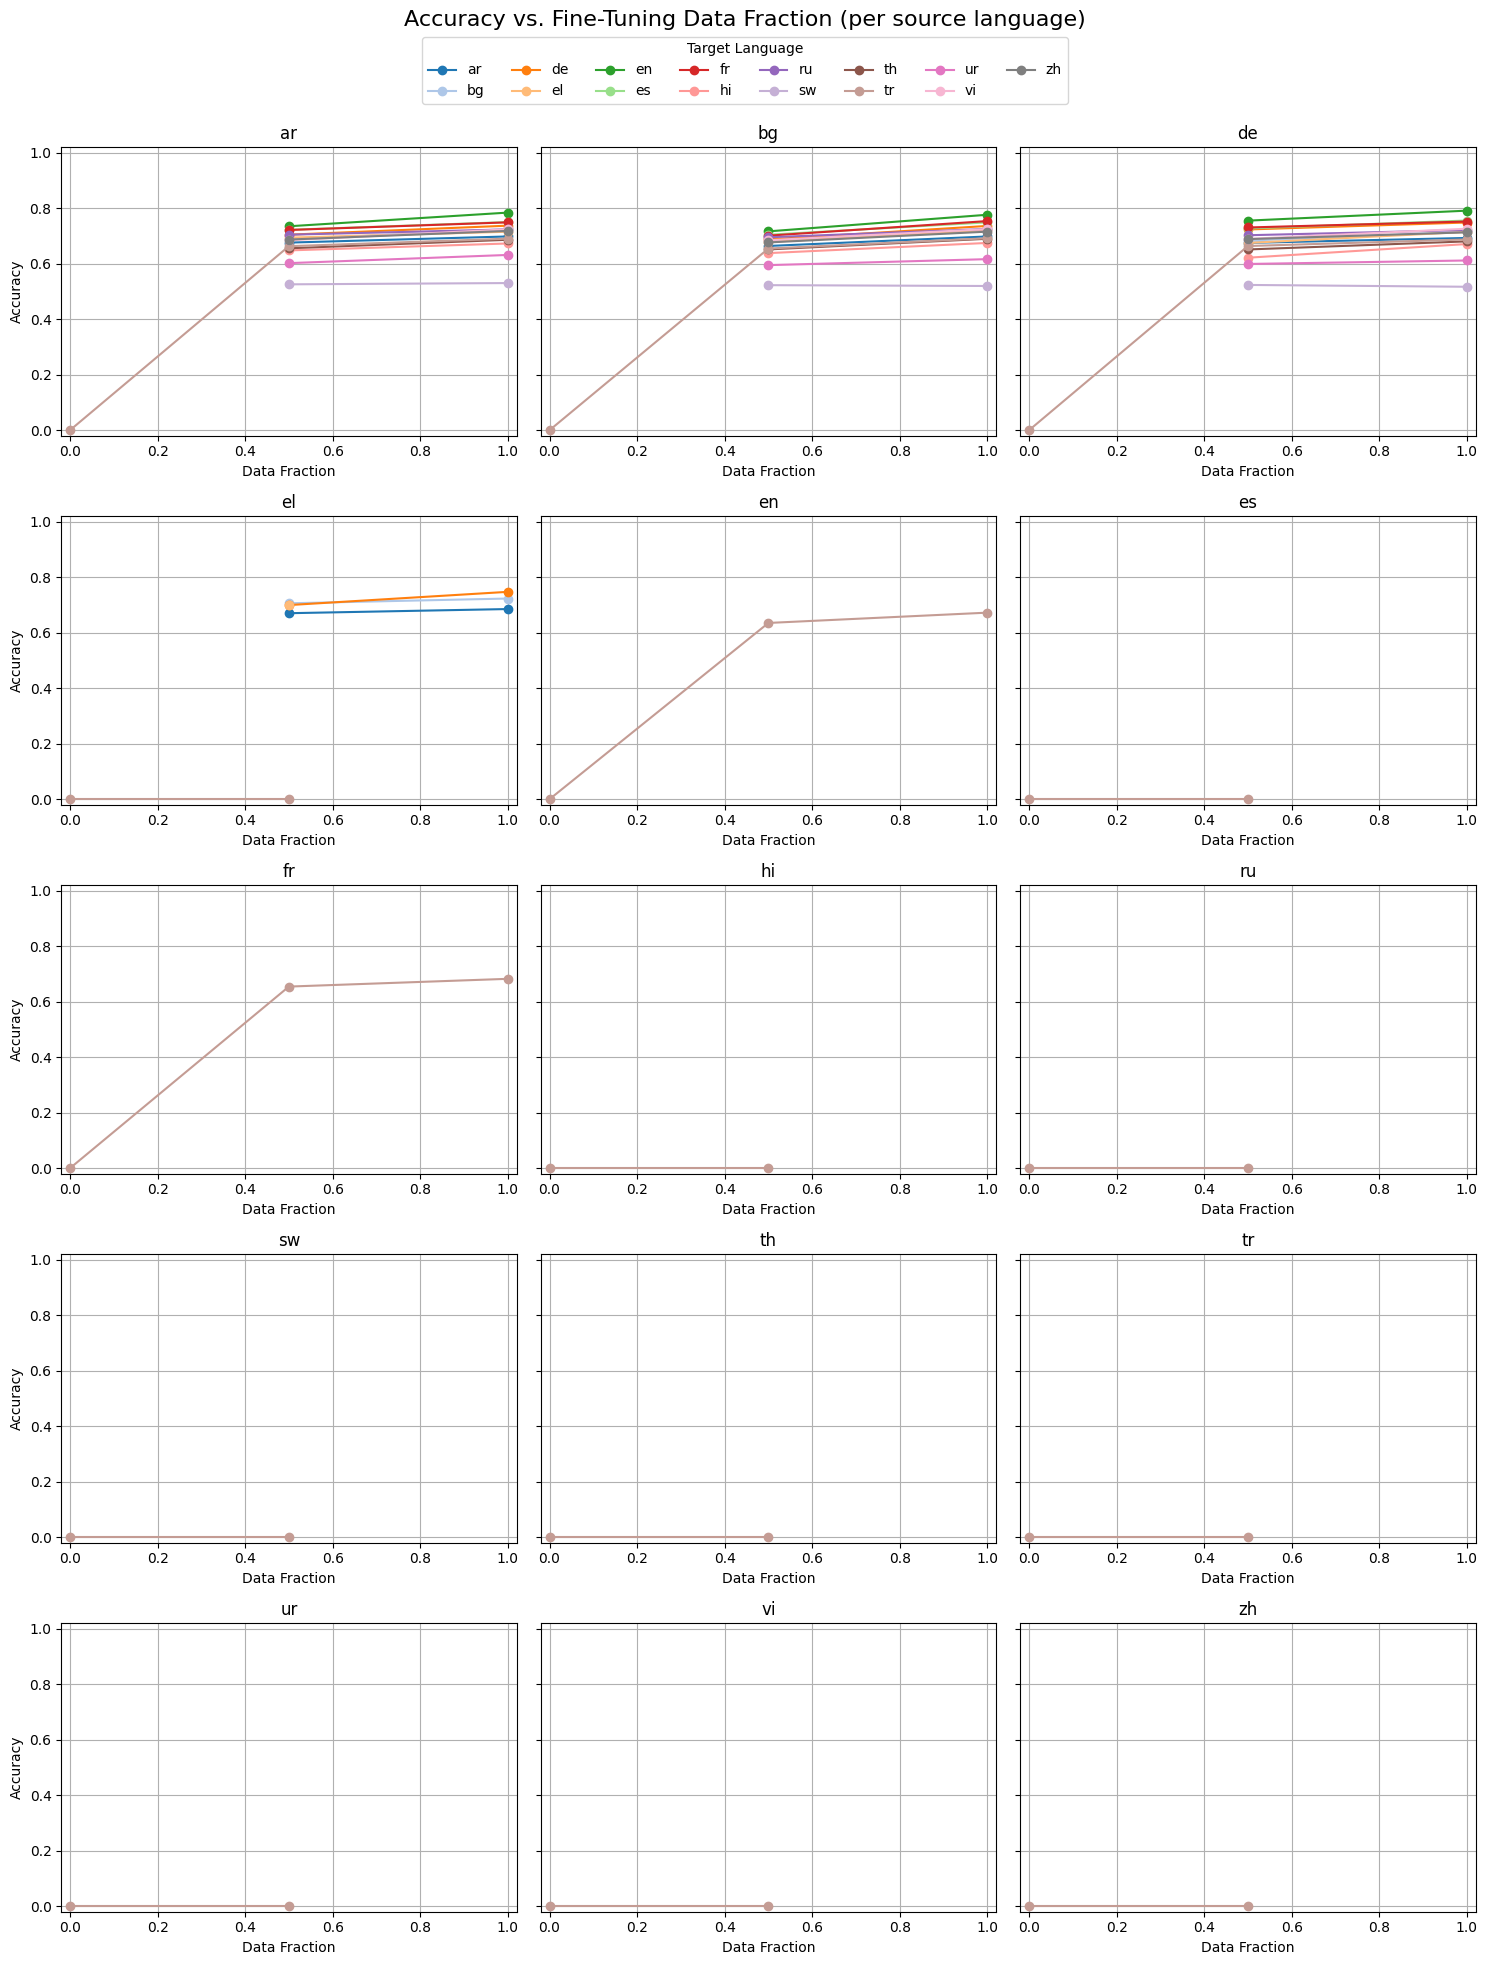

In [148]:
data_fractions = list(results_per_eval[next(iter(results_per_eval))][next(iter(results_per_eval[next(iter(results_per_eval))]))].keys())
plot_accuracy_vs_data_fraction_per_source(results_per_train, fractions=data_fractions, metric='accuracy')

## RQ3. English universality: Given the overwhelming prevalence of English in the training data, is it a good candidate for the universal transfer language?

- Evaluate how well English transfers compared to other source languages.
    - For each target language, compare performance when model is fine-tuned on English vs. other sources (at equal data fraction).
    - For each target language, compute the rank of English among all sources.
    - Check variance in English’s performance as source


### Distribution of accuracy per source language

In [ ]:
def plot_violin_source_transfer_performance(results_per_train, data_fraction=1.0, metric='accuracy'):
    data_fraction = str(data_fraction)  # in case keys are strings

    records = []

    for source_lang in results_per_train:
        for target_lang in results_per_train[source_lang]:
            if target_lang == source_lang:
                continue  # skip self-transfer if not needed
            try:
                score = results_per_train[source_lang][target_lang][data_fraction][metric]
                if score is not None:
                    records.append({
                        'Source': source_lang,
                        'Target': target_lang,
                        'Accuracy': score
                    })
            except KeyError:
                continue

    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Plot violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x='Source', y='Accuracy', inner='box', palette='muted')
    plt.title(f"Distribution of Transfer Performance per Source Language (data fraction = {data_fraction})")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3570009/3835353050.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Source', y='Accuracy', inner='box', palette='muted')


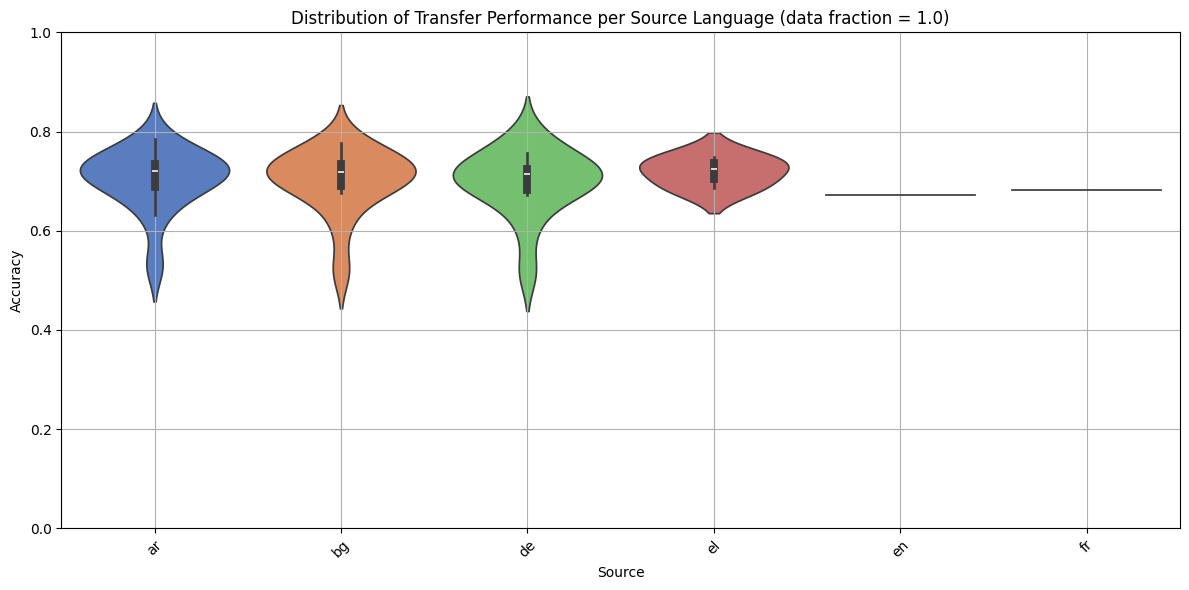

In [156]:
plot_violin_source_transfer_performance(results_per_train, data_fraction=1.0, metric='accuracy')

In [157]:
def compute_english_rank_across_targets(results_per_train, data_fractions, metric='accuracy', english_code='en'):
    rank_records = []

    for frac in data_fractions:
        frac_key = str(frac)

        for target_lang in results_per_train:
            if target_lang == english_code:
                continue  # skip self-transfer

            source_scores = []
            for source_lang in results_per_train:
                if source_lang == target_lang:
                    continue  # optionally skip self-transfer
                try:
                    score = results_per_train[source_lang][target_lang][frac_key][metric]
                    if score is not None:
                        source_scores.append((source_lang, score))
                except KeyError:
                    continue

            # Rank sources by descending score
            source_scores.sort(key=lambda x: x[1], reverse=True)
            ranks = {lang: rank+1 for rank, (lang, _) in enumerate(source_scores)}

            # Get English rank (if available)
            if english_code in ranks:
                english_rank = ranks[english_code]
                total_sources = len(ranks)
                rank_records.append({
                    'Target': target_lang,
                    'Data Fraction': frac,
                    'English Rank': english_rank,
                    'Total Sources': total_sources
                })

    return pd.DataFrame(rank_records)


In [160]:
fractions = [0.0, 0.25, 0.5, 0.75, 1.0]
english_ranks_df = compute_english_rank_across_targets(results_per_train, fractions)

english_ranks_df

,Target,Data Fraction,English Rank,Total Sources
0,tr,0.0,5,14
1,tr,0.5,5,14
2,tr,1.0,5,5


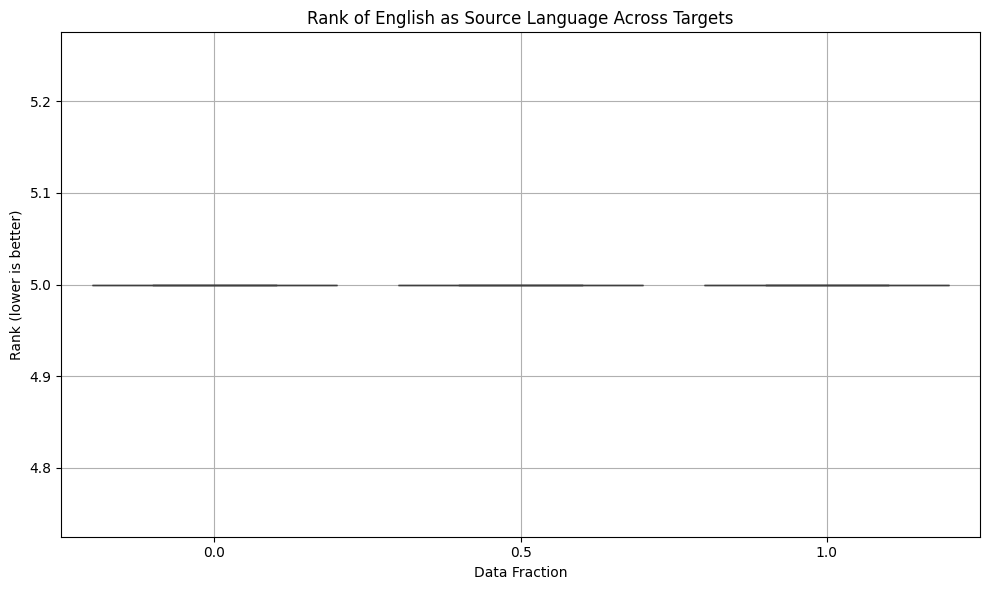

In [161]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=english_ranks_df, x='Data Fraction', y='English Rank')
plt.title("Rank of English as Source Language Across Targets")
plt.ylabel("Rank (lower is better)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [173]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_sources_for_targets(results_per_train, target_langs, data_fraction=1.0, metric='accuracy'):
    data_fraction = str(data_fraction)
    source_langs = list(results_per_train.keys())

    # Assign colors
    colors = plt.get_cmap("tab10").colors  # supports up to 10 targets distinctly
    color_map = {lang: colors[i % len(colors)] for i, lang in enumerate(target_langs)}

    # Get consistent labels across all targets (union of available sources)
    labels = sorted({src for src in source_langs if src not in target_langs})  # exclude targets as sources
    num_vars = len(labels)

    # Compute angles for the radar plot
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    # Start plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for target_lang in target_langs:
        accuracies = []

        for source_lang in labels:
            try:
                score = results_per_train[source_lang][target_lang][data_fraction][metric]
                accuracies.append(score if score is not None else 0)
            except KeyError:
                accuracies.append(0)

        # Close the radar loop
        accuracies.append(accuracies[0])
        color = color_map[target_lang]

        # Plot for this target
        ax.plot(angles, accuracies, marker='o', label=target_lang, color=color, linewidth=2, alpha=0.8)
        ax.fill(angles, accuracies, alpha=0.1, color=color)

    # Ticks and layout
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0, 1)
    ax.set_title(f"{metric.capitalize()} Transfer from Sources to Targets (data fraction = {data_fraction})", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05), title="Target Language")
    plt.tight_layout()
    plt.show()


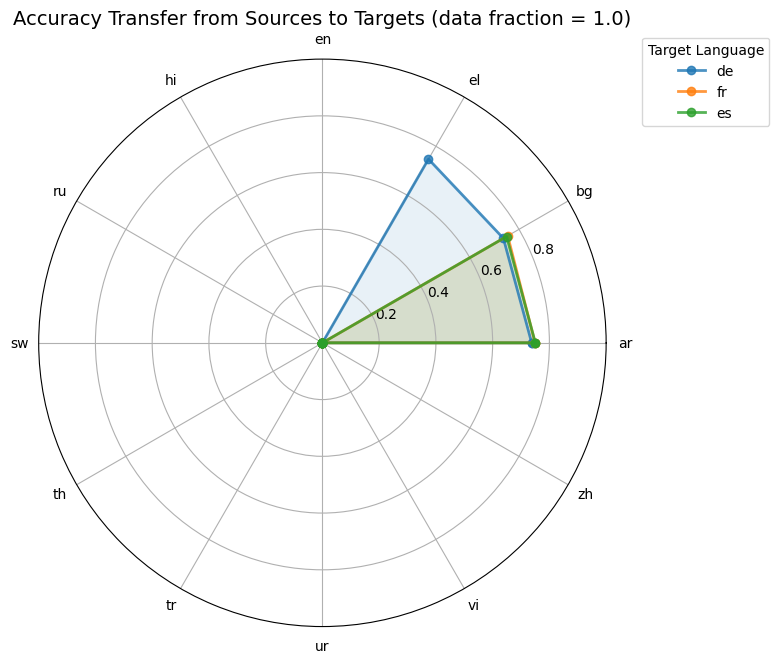

In [174]:
plot_radar_sources_for_targets(
    results_per_train,
    target_langs=['de', 'fr', 'es'],  # your selected targets
    data_fraction=1.0
)
